# Data Analysis: Temperature Runs 
Power Spectrum Data analysis for each equilibrium runs over various temperature Temperature have arbitary units ranging from $T_{bath} = [0.03, 1.5]$ with a step of $dT_{bath} = 0.03$. Value of $\textbf{Critical Temperature}$ is $T_C \sim 1.32$. 
For each temperature, multiple runs are conducted over serveral processors each generating a time series $R(t)$ which stored into files "t_data_#.dat" where '#' corresponds to each increasing temperature value. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [3]:

path = "test3/"
Alldata = np.loadtxt(path + "delta_f2py_test.dat")
print(np.shape(Alldata))
nn = np.size(Alldata,0)
print(nn)

T_up = Alldata[0:nn,0]

R_up = Alldata[0:nn,7]


print("Temperature values (in arbittary units) :", T_up)

Tcrit = 1.32 ### ------> Value of the critical temperature





(50, 11)
50
Temperature values (in arbittary units) : [0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42
 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81 0.84
 0.87 0.9  0.93 0.96 0.99 1.02 1.05 1.08 1.11 1.14 1.17 1.2  1.23 1.26
 1.29 1.32 1.35 1.38 1.41 1.44 1.47 1.5 ]


Following lines help isolate the data for each temperature values. Values are choesn arbitarily can be altered to produce other cases. Note : Check line:9

In [4]:
inputs = open(path+"input_par.dat", "r")

print(inputs.read())


{'g6': 0.5, 'g4': -1.0, 'g2': 1.0, 'coef': 0.1, 'nskip': 1, 'tloop': True, 'dphi': 0.2, 'Tc': 1.0, 'mfphi': False, 'r0': 3.5, 'Rload': 1.0, 'nwarm': 400000, 'my': 64, 'mx': 64, 'gamma': 0.1}{'Tbath': 0.4, 'seed': 3941243, 'maxE': 15.2, 'nmeas': 8192, 'dTb': 0.03, 'dE': 0.2, 'minT': 0.03, 'Tcrit': 0.55, 'maxT': 1.53, 'minE': 0.2}


## Power Spectrum Calculation 
For the analysis part, we sort the data from each processor runs for every single temperature value into arrays and compute the PSD using Welch Method. The different PSDs for each processor are then averaged over the number of processors out to produce a single PSD for every temeperature.  

(50, 4, 8192) (50, 4, 513) (50, 513) (50, 8192)


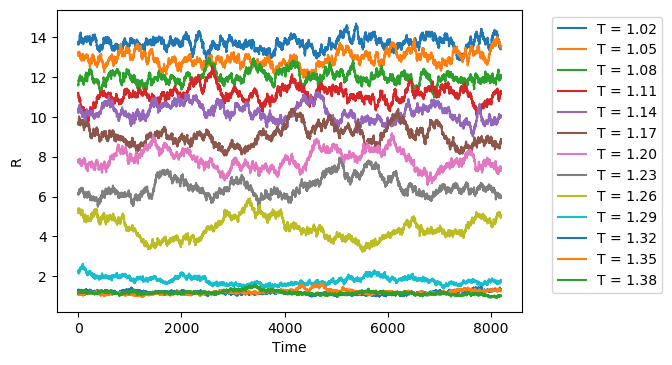

In [5]:
### Number of Processors
NP = 4

### Number of Data points
nmeas = 8192

kk = 0

Tdata = []
PSD2 = []
Omega = []
dRdata = []
fs = 1000.

beta = 10.0
window_length = 1024

numoverlap = window_length/2.
kaiserw = signal.get_window(('kaiser', beta), window_length) # Kaiser window


for i in range(nn):
    tdata = np.loadtxt(path + "t_data_" + str(i) + ".dat") #### Loading Data for each temperature point
    tdata = tdata.reshape((NP,nmeas))     #### Sorting Data into arrays of respective sizes (num of Processors, num of data points)
    R0 = np.mean(tdata,axis=1)            
    R0 = R0.reshape((NP,1))             
    R0 = np.dot(R0,np.ones((1,nmeas)))
#     print(R0)
    delR = tdata - R0     #### Noise time series 
#     fval, R_ps = np.absolute(signal.welch((delR/R0), fs)
    fval, R_ps = np.absolute(signal.welch((delR/R0), fs, nperseg = window_length, window=kaiserw, noverlap = numoverlap, scaling = 'spectrum')) ## PSD using welch method
#     fval, R_ps = np.absolute(signal.welch((delR/R0), fs, nperseg = window_length, window=boxcarw, noverlap = numoverlap)) ## PSD using welch method
    Tdata.append(tdata)
    dRdata.append(delR[kk,:]/R0[kk,:])
    PSD2.append(R_ps)
    Omega.append(fval)
#     plt.plot(delR[kk,:]/R0[kk,:] , label = "Vt = " + format(T_up[i], '.2f') )
    if T_up[i] > 1.0 and T_up[i] < 1.4:
        plt.plot(tdata[kk,:], label = "T = " + format(T_up[i], '.2f') )
#         plt.plot(delR[kk,:] , label = "T = " + format(T_up[i], '.2f') )


    
Tdata = np.array(Tdata)
PSD2 = np.array(PSD2)
Omega = np.array(Omega)
dRdata = np.array(dRdata)
print(np.shape(Tdata) , np.shape(PSD2) , np.shape(Omega) ,np.shape(dRdata))
plt.xlabel("Time")
# plt.ylabel(r'$\frac{\Delta R}{\langle R \rangle}$', fontsize = 16)
plt.ylabel("R")
# # plt.ylim(0,10)
# plt.xlim(1000,1500)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title("dR vs t, $N_{skip} = 4$ , $m_x = m_y = 64$  ")
# plt.savefig(path+"Rvt.pdf",bbox_inches='tight')
plt.show()

(50, 4, 513) (50, 513)


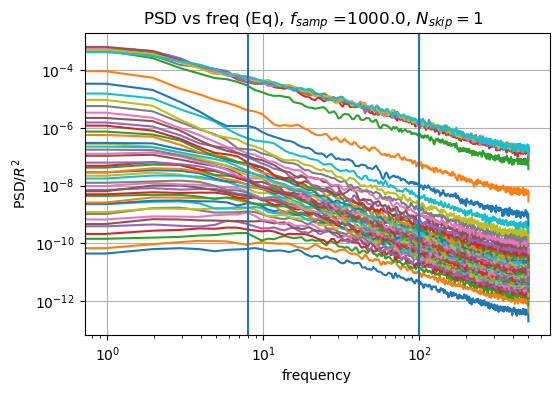

In [6]:
# print(Omega[1,:])
PSD_av = np.mean(PSD2,axis=1)
print(np.shape(PSD2) , np.shape(PSD_av))
upper = 100.
lower = 8.
for i in range(nn):
    PSD_av[i,:] = PSD_av[i,:]/Alldata[i,7]**2  ## Normalized PSD

for i in range(nn):
#     if T_up[i] <= Tcrit:
#         plt.loglog(Omega[i,:], PSD_av[i,:], label = "T = " + format(T_up[i], '.3f'))#,linestyle='dashed' )
#     else :    
#         plt.loglog(Omega[i,:], PSD_av[i,:], label = "T = " + format(T_up[i], '.3f'),linestyle='dashed' )    

    plt.loglog(Omega[i,:], PSD_av[i,:])

PSD_snap = PSD_av[:,Omega[0,:] == 100.5859375] 
plt.title("PSD vs freq (Eq), $f_{samp}$ ="+ format(fs, '.1f') + ", $N_{skip} = 1$  ")
plt.ylabel("PSD/$R^2$")
plt.xlabel("frequency")
# plt.xlim(1,1000)
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(x=lower)  #### Lower cut-off range
plt.axvline(x=upper)  #### Upper cut-off range
# plt.ylim(1.0E-9,1.0E-2)

plt.grid(b=True,which='major', axis='both')
# plt.legend()
# plt.savefig(path+"PSDvf_ns1.pdf")
plt.show()

## Computing $\alpha$   
We compute $\alpha$ in the range given above. The range again is chosen to avoid the higher frequency values and the low frequency white noise part of the spectra. 

1.32


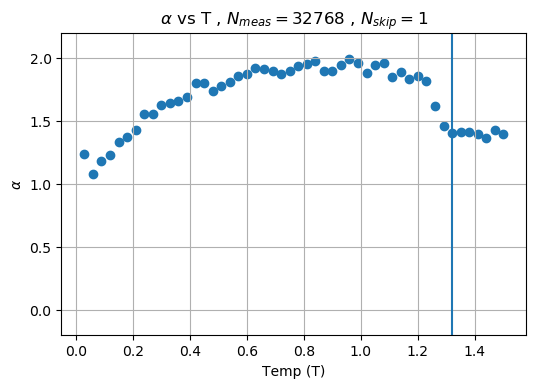

In [7]:
alpha_up = []
alpha_dn = []
yint = []
print(Tcrit)

upper_cut_off = int(np.argwhere(np.around(Omega[0,:]) == int(upper)))
lower_cut_off = int(np.argwhere(np.around(Omega[0,:]) == int(lower)))

for i in range(nn):
    if T_up[i] <= Tcrit:
        lg_Omega = np.log(Omega[i,lower_cut_off:upper_cut_off])
        lg_PSD = np.log(PSD_av[i,lower_cut_off:upper_cut_off])
        p = np.polyfit(lg_Omega, lg_PSD, deg = 1)
    else: 
        lg_Omega = np.log(Omega[i,lower_cut_off:upper_cut_off])
        lg_PSD = np.log(PSD_av[i,lower_cut_off:upper_cut_off])
        p = np.polyfit(lg_Omega, lg_PSD, deg = 1)
    alpha_up.append(-p[0])
    yint.append(p[1])
    
# cutofffreq = window_length//2
# for i in range(nn):
#     lg_Omega = np.log(Omega[i,1:])
#     lg_PSD = np.log(PSD[i,1:])
#     p = np.polyfit(lg_Omega, lg_PSD, deg = 1)
# #     slope, intercept, r_value, p_value, std_err = stats.linregress(lg_Omega, lg_PSD)
# #     alpha_up.append(-slope)
#     alpha_up.append(-p[0])

alpha_up = np.array(alpha_up)
alpha_dn = np.array(alpha_dn)
yint = np.array(yint)
# print(alpha_up)
# print("Maximum alpha " , np.max(alpha_up))
# print("Alpha at chosen critical point :", alpha_up[k2] )
# print(Vt_up[int(np.argmax(alpha_up))])

# print(np.shape(alpha_up), np.shape(alpha_dn))
# np.savetxt(path + "A_m1_02.dat", alpha_up)


# plt.plot(E_up,alpha_up,label="Up")
plt.scatter(T_up[0:nn],alpha_up,label="Up")
# plt.scatter(T_up[0:nn],Alldata[0:nn,1])
# plt.scatter(E_dn_py,alpha_dn, c = "RoyalBlue", label="Down")
plt.title(r'$\alpha$' + " vs T , $N_{meas} = 32768$ , $N_{skip} = 1$")
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# np.savetxt(path+"alpha_n16.dat", alpha_up)
# plt.xlim(20.0,30.0)
plt.ylim(-0.2,2.2)
plt.axvline(x=Tcrit)
plt.xlabel(r'Temp (T)')
plt.ylabel(r'$\alpha$')
plt.grid(b=True,which='major', axis='both')
# plt.savefig(path+"alpvf_ns1.pdf")
plt.show()
    





## Plotting different cases of PSD 
#### (temperature has been re-scaled in this part for a better understanding of the physics near and away from $T_C$)

We also check our fit of the PSD and corresponding time series values around for various cases of the temperature picked above.

In [16]:
# #### Folowing lines helps in isolating cases for Each temperature 
print("Temperature Values : ", T_up)
k1 = int(np.argwhere((T_up*10.) == 3.2))  #### ----> 0.24Tc
k2 = int(np.argwhere((T_up*10.) == 10.0)) #### ----> 0.75Tc
k3 = int(np.argwhere((T_up*10.) == 12.0)) #### ----> 0.9Tc 
k4 = int(np.argwhere((T_up*10.) == 12.8)) #### ----> 0.97Tc
k5 = int(np.argwhere((T_up*10.) == 16.0)) #### ----> 1.2Tc
print(k1,k2,k3,k4,k5)
karr = np.array([k1,k2,k3,k4,k5])
tempval = np.array([0.25,0.5,0.9,0.95,1.14])

Temperature Values :  [0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42
 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81 0.84
 0.87 0.9  0.93 0.96 0.99 1.02 1.05 1.08 1.11 1.14 1.17 1.2  1.23 1.26
 1.29 1.32 1.35 1.38 1.41 1.44 1.47 1.5 ]
10 21 39 41 49


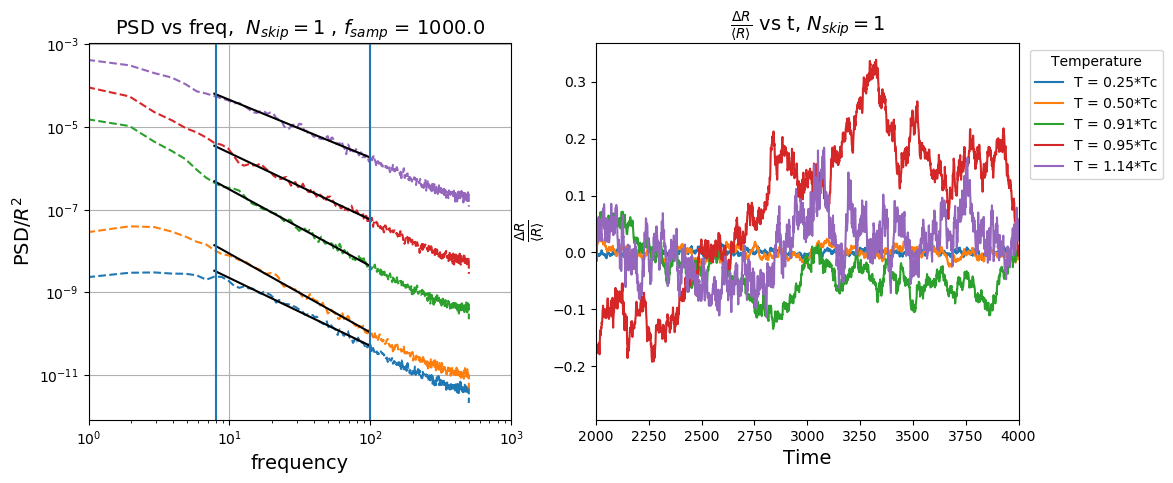

In [21]:
def ff(xx,a,b):
    return (1/xx**a)*np.exp(b)


f = plt.figure(figsize=(12, 5)); # plot the calculated values    

sp =  f.add_subplot(1, 2, 1 );
for kk in karr:
#     kk = kkk-1
    plt.loglog(Omega[kk,:], PSD_av[kk,:], linestyle = "dashed" )#, label = "T = " + format(T_up[kk], '.2f') 
    plt.loglog(Omega[kk,lower_cut_off:upper_cut_off],ff(Omega[kk,lower_cut_off:upper_cut_off],alpha_up[kk],yint[kk]), color = 'black')
#     np.savetxt(path + "PSD_"+format(T_up[kk]/Tcrit, '.2f') + "Tc.dat",Omega[kk,:], PSD_av[kk,:] )
    
    
plt.title("PSD vs freq,  $N_{skip} = 1$ , $f_{samp}$ = "+ format(fs, '.1f'), fontsize = 14 )
plt.ylabel("PSD/$R^2$", fontsize = 14)
plt.xlabel("frequency", fontsize = 14)
plt.xlim(1,1000)
# # plt.legend()
plt.axvline(x=lower)
plt.axvline(x=upper)
# plt.ylim(1.0E-9,1.0E-2)
# plt.savefig(path+"PSDvf.pdf")
plt.grid(b=True,which='major', axis='both')
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

sp =  f.add_subplot(1, 2, 2 );
for kk in karr:
#     kk = kkk-1
#     plt.plot(Tdata[kk,0,:], label = "T = " + format(T_up[kk], '.2f') )
    plt.plot(dRdata[kk,:], label = "T = " + format(T_up[kk]/Tcrit, '.2f') + "*Tc" )
    
plt.xlabel("Time", fontsize = 14)
plt.ylabel(r'$\frac{\Delta R}{\langle R \rangle}$', fontsize = 14)
# plt.ylabel("R")
# plt.xlim(100,1200)
# plt.xlim(1200,1600)
plt.xlim(2000,4000)
# plt.xlim(4500,5000)
plt.legend(title="Temperature", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title(r'$\frac{\Delta R}{\langle R \rangle}$ vs t, $N_{skip} = 1$', fontsize = 14)
# # plt.savefig(path+"Rvt.pdf")
# plt.show()


# plt.savefig(path+"Case_cc_ns1.pdf",bbox_inches='tight')

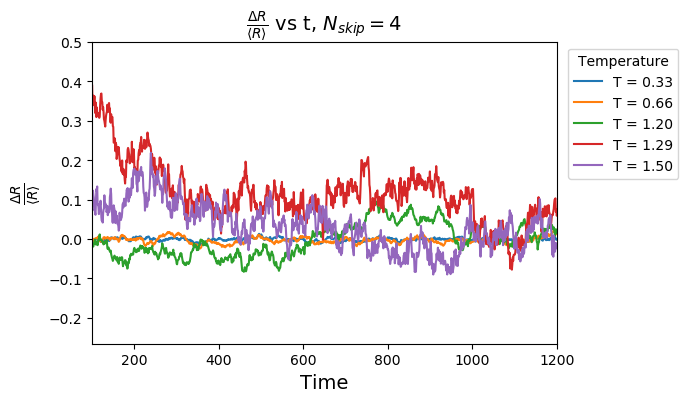

In [10]:
for kk in karr:
#     plt.plot(Tdata[kk,0,:], label = "T = " + format(T_up[kk], '.2f') )
    plt.plot(dRdata[kk,:], label = "T = " + format(T_up[kk], '.2f') )
    
plt.xlabel("Time", fontsize = 14)
plt.ylabel(r'$\frac{\Delta R}{\langle R \rangle}$', fontsize = 14)
# plt.ylabel("R")
plt.xlim(100,1200)
plt.legend(title="Temperature", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title(r'$\frac{\Delta R}{\langle R \rangle}$ vs t, $N_{skip} = 4$', fontsize = 14)
# plt.title(r'R vs t, $N_{skip} = 4$', fontsize = 14)
# plt.savefig(path+"dRvt.pdf",bbox_inches='tight')
plt.show()